In [2]:
import openslide
from openslide.deepzoom import DeepZoomGenerator
import dask.array as da
import numpy as np

In [3]:
# import dask.array as da
from dask import delayed 

In [6]:
def load_svs_with_dask(path):

    slide = openslide.OpenSlide(path)
    dz = DeepZoomGenerator(slide, tile_size=254, overlap=1, limit_bounds=False)
    
    @delayed(pure=True)
    def get_tile(level, column, row):
        tile = dz.get_tile(level, (column, row))
        return np.array(tile).transpose((1, 0, 2))

    layers = []
    for level in range(dz.level_count - 1, -1, -1):  # Reverse to ensure smallest to largest
        level_tiles = dz.level_tiles[level]
        sample_tile_shape = get_tile(level, 0, 0).shape.compute()
        n_tiles_x, n_tiles_y = level_tiles[0], level_tiles[1]
        
        level_dimensions = dz.level_dimensions[level]
        if n_tiles_x <= 1 or n_tiles_y <= 1:
            print(
                f"Ignoring Level {level} with dimensions: {level_dimensions}"
            )
            continue
        else:
            print(f"Reading Level {level} with dimensions: {level_dimensions}")
        
        rows = range(n_tiles_y - 1)
        cols = range(n_tiles_x - 1)
        # Convert list of delayed operations to dask array only once
        layer = da.concatenate(
            [
                da.concatenate(
                    [
                        da.from_delayed(
                            get_tile(level, col, row),
                            sample_tile_shape,
                            np.uint8,
                        )
                        for row in rows
                    ],
                    allow_unknown_chunksizes=False,
                    axis=1,
                    )
                    for col in cols
                ],
                allow_unknown_chunksizes=False,
            )
        layers.append(layer)
    return layers
    


In [7]:
myPyramid = load_svs_with_dask('/archive/bioinformatics/Zhou_lab/shared/jjin/project/Software_Engineering_final/imgs/TCGA-CZ-4863-01Z-00-DX1.7f3da3a1-5d70-4d30-a9f3-80ab883cf9f6.svs')


Reading Level 16 with dimensions: (48010, 42761)
Reading Level 15 with dimensions: (24005, 21381)
Reading Level 14 with dimensions: (12003, 10691)
Reading Level 13 with dimensions: (6002, 5346)
Reading Level 12 with dimensions: (3001, 2673)
Reading Level 11 with dimensions: (1501, 1337)
Reading Level 10 with dimensions: (751, 669)
Reading Level 9 with dimensions: (376, 335)
Ignoring Level 8 with dimensions: (188, 168)
Ignoring Level 7 with dimensions: (94, 84)
Ignoring Level 6 with dimensions: (47, 42)
Ignoring Level 5 with dimensions: (24, 21)
Ignoring Level 4 with dimensions: (12, 11)
Ignoring Level 3 with dimensions: (6, 6)
Ignoring Level 2 with dimensions: (3, 3)
Ignoring Level 1 with dimensions: (2, 2)
Ignoring Level 0 with dimensions: (1, 1)


In [191]:
from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize

RuntimeError: Please install TensorFlow: https://www.tensorflow.org/install/

In [183]:
def load_svs_with_dask_hed_1(path):
    model = StarDist2D.from_pretrained("2D_versatile_he")
    slide = openslide.OpenSlide(path)
    dz = DeepZoomGenerator(slide, tile_size=254, overlap=1, limit_bounds=False)
    
    @delayed(pure=True)
    def get_tile(level, column, row):
        tile = dz.get_tile(level, (column, row))
        return np.array(tile).transpose((1, 0, 2))
    
    @delayed(pure=True)
    def get_tile_hed(level, column, row, threshold=0.05):
        tile = dz.get_tile(level, (column, row))
        tile = np.array(tile).transpose((1, 0, 2))
        hed_title = rgb2hed(tile)
        mask = np.zeros((*tile.shape[:2], 3), dtype=np.uint8)
        mask[hed_title > threshold] = 255
        mask[:, :, 1:] = 0
        return mask

    

    layers = []
    layers_hed = []
    for level in range(dz.level_count - 1, -1, -1):  # Reverse to ensure smallest to largest
        level_tiles = dz.level_tiles[level]
        sample_tile_shape = get_tile(level, 0, 0).shape.compute()
        n_tiles_x, n_tiles_y = level_tiles[0], level_tiles[1]
        
        level_dimensions = dz.level_dimensions[level]
        if n_tiles_x <= 1 or n_tiles_y <= 1:
            print(
                f"Ignoring Level {level} with dimensions: {level_dimensions}"
            )
            continue
        else:
            print(f"Reading Level {level} with dimensions: {level_dimensions}")
        
        rows = range(n_tiles_y - 1)
        cols = range(n_tiles_x - 1)
        # Convert list of delayed operations to dask array only once
        layer = da.concatenate(
            [
                da.concatenate(
                    [
                        da.from_delayed(
                            get_tile(level, col, row),
                            sample_tile_shape,
                            np.uint8,
                        )
                        for row in rows
                    ],
                    allow_unknown_chunksizes=False,
                    axis=1,
                    )
                    for col in cols
                ],
                allow_unknown_chunksizes=False,
            )
        layer_hed = da.concatenate(
            [
                da.concatenate(
                    [
                        da.from_delayed(
                            get_tile_hed(
                                level, col, row, threshold=0.05
                            ),
                            sample_tile_shape,
                            np.uint8,
                        )
                        for row in rows
                    ],
                    allow_unknown_chunksizes=False,
                    axis=1,
                )
                for col in cols
            ],
            allow_unknown_chunksizes=False,
        )
        layers.append(layer)
        layers_hed.append(layer_hed)
    return layers, layers_hed

def rgb2hed(rgb):
    hed_inverse_T = np.array(
            [
                [1.87798274, -1.00767869, -0.55611582],
                [-0.06590806, 1.13473037, -0.1355218],
                [-0.60190736, -0.48041419, 1.57358807],
            ]
        )
    # print(rgb.shape)
    hed = (np.log((rgb)/255) / np.log(1e-6)) @ hed_inverse_T
    return hed

def rgb2hed_dask(rgb_dask):
    hed_inverse_T = np.array(
            [
                [1.87798274, -1.00767869, -0.55611582],
                [-0.06590806, 1.13473037, -0.1355218],
                [-0.60190736, -0.48041419, 1.57358807],
            ]
        )
    # print(rgb_dask.shape)
    hed = (np.log((rgb_dask)/255) / np.log(1e-6)) @ hed_inverse_T
    return hed

def rgb2hed_dask_1(rgb_dask):
    # 将输入转换为 Dask 数组
    # rgb_dask = da.from_array(rgb, chunks=rgb.shape)
    
    # 染色向量（赫姆赛通，伊红，DAB）
    stain_matrix = da.array([[0.650, 0.704, 0.286],
                             [0.072, 0.990, 0.105],
                             [0.268, 0.570, 0.776]])
    
    # 转换为光学密度
    eps = 1e-5
    od = da.log((rgb_dask + 1) / 256 + eps)
    
    # 使用 Dask 转换为 HED 空间
    hed = da.dot(od, da.linalg.inv(stain_matrix).T)
    hed = da.maximum(hed, 0)
    # hed_binary_image = apply_threshold(hed, threshold=0.05)
    return hed
    # return hed_binary_image

def apply_threshold(hed_image, threshold=0.05):
    """
    Apply a simple threshold to the HED image, typically on the first channel (Hematoxylin).

    Parameters:
    hed_image (dask.array): The HED image array.
    threshold (float): Threshold value to apply.

    Returns:
    dask.array: A binary image where pixels above the threshold are set to 1, others to 0.
    """
    # Assuming thresholding on the first channel (Hematoxylin)
    binary_image = da.where(hed_image[..., 0] > threshold, 1, 0)
    return binary_image


In [184]:
myPyramid = load_svs_with_dask_hed_1('/archive/bioinformatics/Zhou_lab/shared/jjin/project/Software_Engineering_final/imgs/TCGA-CZ-4863-01Z-00-DX1.7f3da3a1-5d70-4d30-a9f3-80ab883cf9f6.svs')


Reading Level 16 with dimensions: (48010, 42761)
Reading Level 15 with dimensions: (24005, 21381)
Reading Level 14 with dimensions: (12003, 10691)
Reading Level 13 with dimensions: (6002, 5346)
Reading Level 12 with dimensions: (3001, 2673)
Reading Level 11 with dimensions: (1501, 1337)
Reading Level 10 with dimensions: (751, 669)
Reading Level 9 with dimensions: (376, 335)
Ignoring Level 8 with dimensions: (188, 168)
Ignoring Level 7 with dimensions: (94, 84)
Ignoring Level 6 with dimensions: (47, 42)
Ignoring Level 5 with dimensions: (24, 21)
Ignoring Level 4 with dimensions: (12, 11)
Ignoring Level 3 with dimensions: (6, 6)
Ignoring Level 2 with dimensions: (3, 3)
Ignoring Level 1 with dimensions: (2, 2)
Ignoring Level 0 with dimensions: (1, 1)


In [188]:
layers, layers_hed = myPyramid

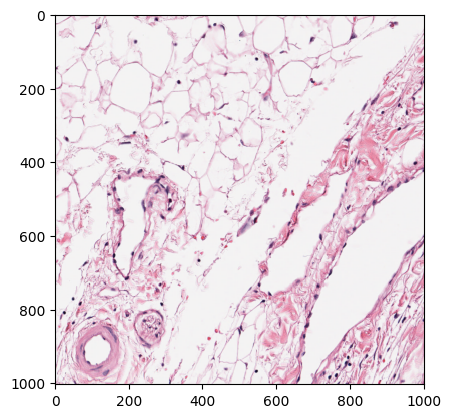

In [189]:
plt.imshow(layers[0][11000:12000, 11000:12000].compute(), cmap='gray')

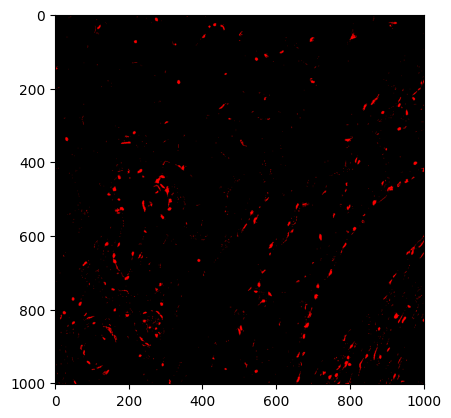

In [190]:
plt.imshow(layers_hed[0][11000:12000, 11000:12000].compute()[:, :])

In [12]:
layers

[dask.array<concatenate, shape=(48195, 42840, 3), dtype=uint8, chunksize=(255, 255, 3), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(23970, 21420, 3), dtype=uint8, chunksize=(255, 255, 3), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(11985, 10710, 3), dtype=uint8, chunksize=(255, 255, 3), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(5865, 5355, 3), dtype=uint8, chunksize=(255, 255, 3), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(2805, 2550, 3), dtype=uint8, chunksize=(255, 255, 3), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(1275, 1275, 3), dtype=uint8, chunksize=(255, 255, 3), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(510, 510, 3), dtype=uint8, chunksize=(255, 255, 3), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(255, 255, 3), dtype=uint8, chunksize=(255, 255, 3), chunktype=numpy.ndarray>]

In [77]:
layers_hed

[dask.array<sum-aggregate, shape=(48195, 42840, 3), dtype=float64, chunksize=(255, 255, 3), chunktype=numpy.ndarray>,
 dask.array<sum-aggregate, shape=(23970, 21420, 3), dtype=float64, chunksize=(255, 255, 3), chunktype=numpy.ndarray>,
 dask.array<sum-aggregate, shape=(11985, 10710, 3), dtype=float64, chunksize=(255, 255, 3), chunktype=numpy.ndarray>,
 dask.array<sum-aggregate, shape=(5865, 5355, 3), dtype=float64, chunksize=(255, 255, 3), chunktype=numpy.ndarray>,
 dask.array<sum-aggregate, shape=(2805, 2550, 3), dtype=float64, chunksize=(255, 255, 3), chunktype=numpy.ndarray>,
 dask.array<sum-aggregate, shape=(1275, 1275, 3), dtype=float64, chunksize=(255, 255, 3), chunktype=numpy.ndarray>,
 dask.array<sum-aggregate, shape=(510, 510, 3), dtype=float64, chunksize=(255, 255, 3), chunktype=numpy.ndarray>,
 dask.array<sum-aggregate, shape=(255, 255, 3), dtype=float64, chunksize=(255, 255, 3), chunktype=numpy.ndarray>]

In [38]:
layers_hed[6]

dask.array<where, shape=(510, 510), dtype=int64, chunksize=(255, 255), chunktype=numpy.ndarray>

In [13]:
layers_hed[6]

dask.array<getitem, shape=(510, 3), dtype=float64, chunksize=(255, 3), chunktype=numpy.ndarray>

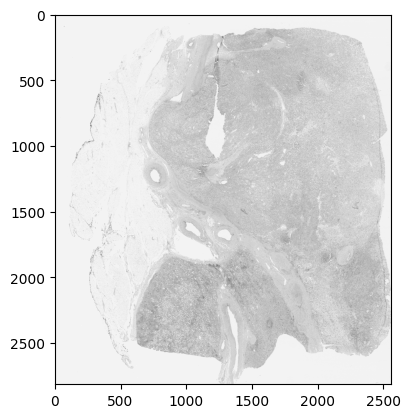

In [52]:
plt.imshow(layers[4][:, :, 0].compute(), cmap='gray')

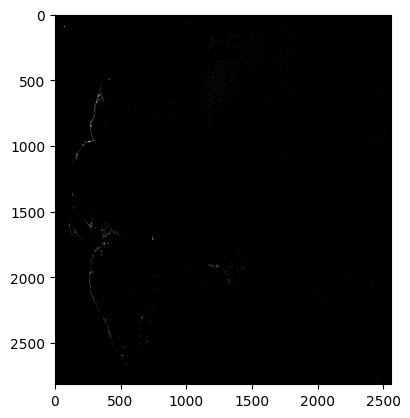

In [51]:
import matplotlib.pyplot as plt
plt.imshow(layers_hed[4][:, :].compute(), cmap='gray')

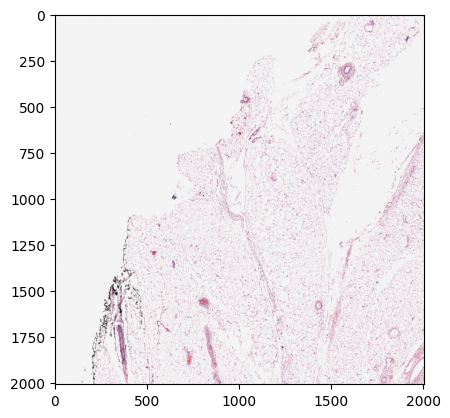

In [62]:
plt.imshow(layers[2][1000:3000, 1000:3000].compute(), cmap='gray')

In [ ]:
plt.imshow(layers[0][10000:11000, 10000:11000].compute(), cmap='gray')

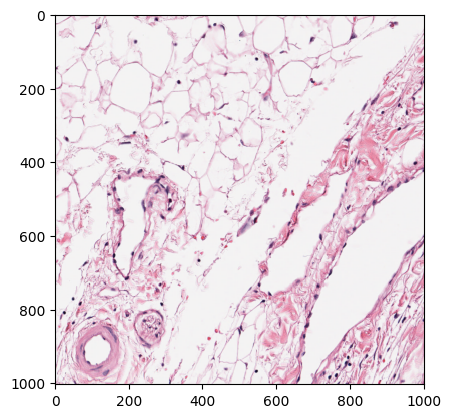

In [75]:
plt.imshow(layers[0][11000:12000, 11000:12000].compute(), cmap='gray')

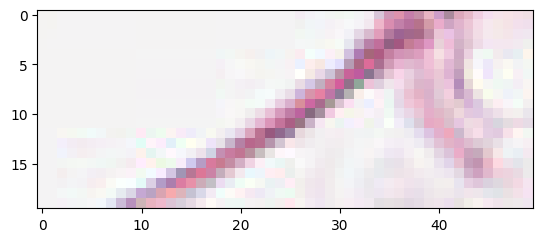

In [112]:
plt.imshow(layers[0][11000:11020, 11010:11060].compute())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-21.618325666316217..12.38411247388528].


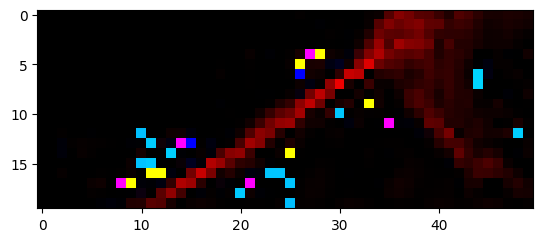

In [113]:
a = layers[0][11000:11020, 11010:11060].compute()
b = np.array([[0.650, 0.704, 0.286],
                             [0.072, 0.990, 0.105],
                             [0.268, 0.570, 0.776]])
eps = 1e-5
od = np.log((a + 1) / 256 + eps)
hed = np.dot(od, np.linalg.inv(b).T)
plt.imshow(hed)

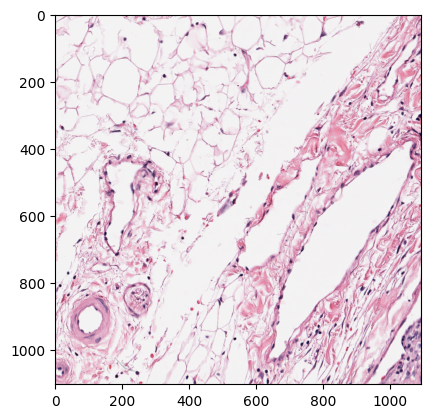

In [122]:
a = layers[0][11000:12100, 11010:12100].compute()
plt.imshow(a)

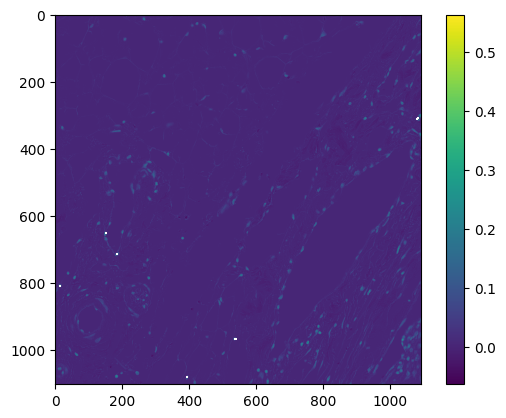

In [147]:
a = layers[0][11000:12100, 11010:12100]
b = np.array(
        [
            [1.87798274, -1.00767869, -0.55611582],
            [-0.06590806, 1.13473037, -0.1355218],
            [-0.60190736, -0.48041419, 1.57358807],
        ]
    )
# eps = 1e-5
# od = np.log((a + 1) / 256 + eps)
hed = (np.log(a/255) / np.log(1e-6)) @ b
plt.imshow(hed[:, :, 0])
plt.colorbar()

/tmp/ipykernel_62047/1217762451.py:11: RuntimeWarning: divide by zero encountered in log
  hed = (np.log(a/255) / np.log(1e-6)) @ b
/tmp/ipykernel_62047/1217762451.py:11: RuntimeWarning: invalid value encountered in matmul
  hed = (np.log(a/255) / np.log(1e-6)) @ b


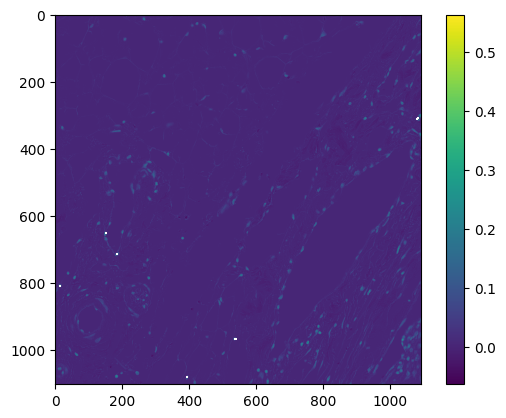

In [128]:
a = layers[0][11000:12100, 11010:12100].compute()
b = np.array(
        [
            [1.87798274, -1.00767869, -0.55611582],
            [-0.06590806, 1.13473037, -0.1355218],
            [-0.60190736, -0.48041419, 1.57358807],
        ]
    )
# eps = 1e-5
# od = np.log((a + 1) / 256 + eps)
hed = (np.log(a/255) / np.log(1e-6)) @ b
plt.imshow(hed[:, :, 0])
plt.colorbar()

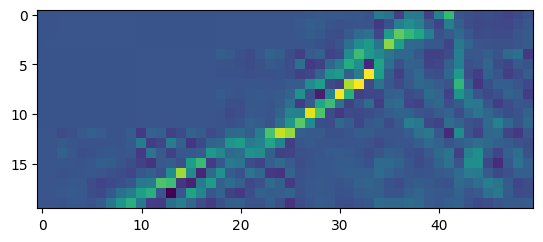

In [126]:
a = layers[0][11000:11020, 11010:11060].compute()
b = np.array(
        [
            [1.87798274, -1.00767869, -0.55611582],
            [-0.06590806, 1.13473037, -0.1355218],
            [-0.60190736, -0.48041419, 1.57358807],
        ]
    )
eps = 1e-5
# od = np.log((a + 1) / 256 + eps)
hed = (np.log(a) / np.log(1e-6)) @ b
plt.imshow(hed[:, :, 0])

In [ ]:
def rgb2hed_dask(rgb_dask):
    # 将输入转换为 Dask 数组
    # rgb_dask = da.from_array(rgb, chunks=rgb.shape)
    
    # 染色向量（赫姆赛通，伊红，DAB）
    stain_matrix = da.array([[0.650, 0.704, 0.286],
                             [0.072, 0.990, 0.105],
                             [0.268, 0.570, 0.776]])
    
    # 转换为光学密度
    eps = 1e-5
    od = da.log((rgb_dask + 1) / 256 + eps)
    
    # 使用 Dask 转换为 HED 空间
    hed = da.dot(od, da.linalg.inv(stain_matrix).T)
    hed = da.maximum(hed, 0)
    # hed_binary_image = apply_threshold(hed, threshold=0.05)
    return hed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..12.38411247388528].


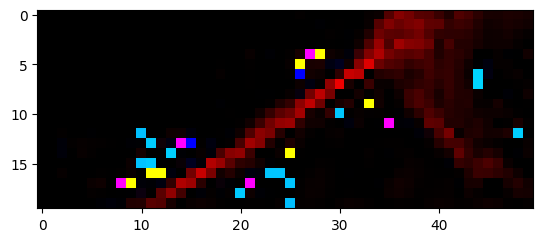

In [109]:
plt.imshow(layers_hed[0][11000:11020, 11010:11060].compute())

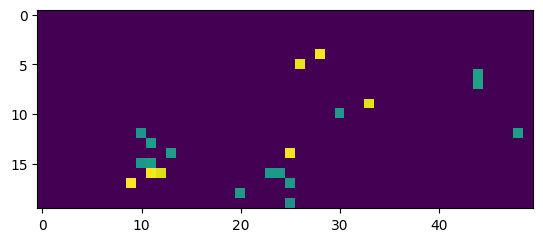

In [108]:
plt.imshow(layers_hed[0][11000:11020, 11010:11060, 1].compute())

In [111]:
a = layers_hed[0][11000:11020, 11010:11060, 1].compute()
print(a[15, 10])

0.7651054252297914


In [110]:
layers_hed[0][11000:11020, 11010:11060, 1].compute()

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.951954640682681..2.7638741446044373].


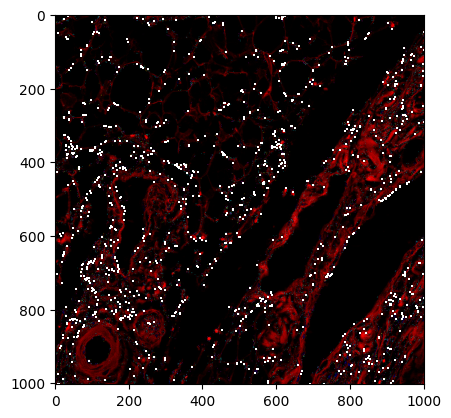

In [90]:
plt.imshow(layers_hed[0][11000:12000, 11000:12000].compute())

In [83]:
layers_hed[0][11000:12000, 11000:12000].compute()

/archive/bioinformatics/Zhou_lab/shared/jjin/software/anaconda3/envs/Napari/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/archive/bioinformatics/Zhou_lab/shared/jjin/software/anaconda3/envs/Napari/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/archive/bioinformatics/Zhou_lab/shared/jjin/software/anaconda3/envs/Napari/lib/python3.9/site-packages/dask/array/routines.py:406: RuntimeWarning: invalid value encountered in matmul
  chunk = xp.matmul(a, b)
/archive/bioinformatics/Zhou_lab/shared/jjin/software/anaconda3/envs/Napari/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/archive/bioinformatics/Zhou_lab/shared/jjin/software/anaconda3/envs/Napari/lib/python3.9/site-packages/da

(1003, 1003, 3)

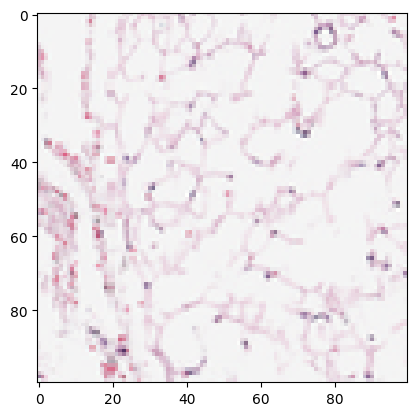

In [63]:
# import matplotlib.pyplot as plt
plt.imshow(layers[3][1000:1100, 1000:1100].compute(), cmap='gray')

ValueError: zero-size array to reduction operation minimum which has no identity

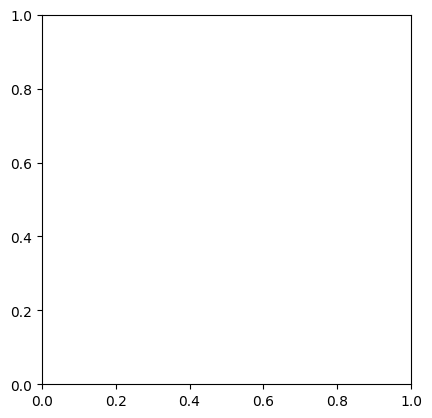

In [72]:
plt.imshow(layers_hed[3][10000:11000, 10000:11000].compute(), cmap='gray')

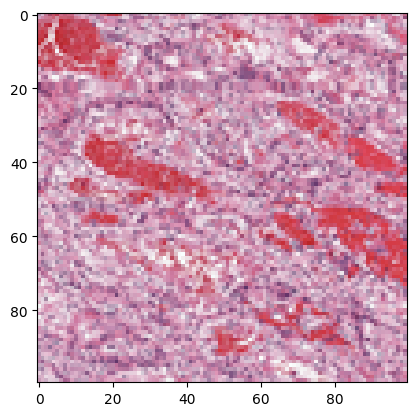

In [73]:
plt.imshow(layers[4][1000:1100, 1000:1100].compute(), cmap='gray')

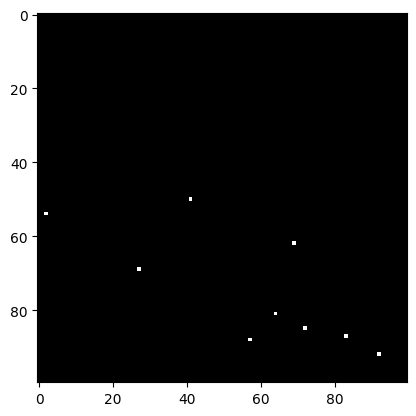

In [65]:
plt.imshow(layers_hed[4][1000:1100, 1000:1100].compute(), cmap='gray')

In [66]:
layers_hed[4][1000:1100, 1000:1100].compute()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

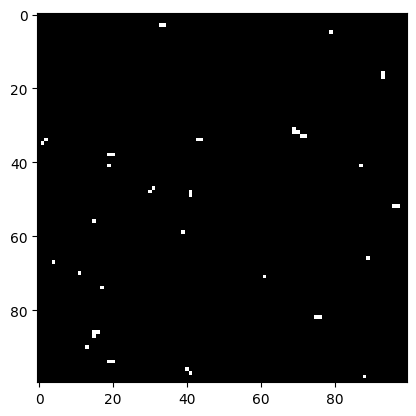

In [59]:
# import matplotlib.pyplot as plt
plt.imshow(layers_hed[3][1000:1100, 1000:1100].compute(), cmap='gray')

In [15]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 6.8 MB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 21.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.0/305.0 kB 36.1 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 44.5 MB/s eta 0:00:0000:0100:01
Using cached importlib_resources-6.4.0-py3-none-any.whl (38 kB)
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)


In [28]:
layers_hed[6][:, :, 0].compute()

array([[ 0.02119752,  0.02119752,  0.02119752, ...,  0.01602903,
         0.01373923,  0.01373923],
       [ 0.02119752,  0.02119752,  0.02119752, ...,  0.01602903,
         0.01373923,  0.01373923],
       [ 0.01892645,  0.02119752,  0.02119752, ...,  0.01602903,
         0.01602903,  0.01602903],
       ...,
       [ 0.00436745,  0.00895653,  0.01892645, ..., -0.28390016,
        -0.29026384, -0.24789671],
       [ 0.00436745,  0.00895653,  0.01892645, ..., -0.25991987,
        -0.27607807, -0.26985637],
       [ 0.00436745,  0.01123693,  0.01892645, ..., -0.31171804,
        -0.38134356, -0.33543975]])